In [1]:
import numpy as np
import imageio as misc
import numpy as np
import matplotlib.pyplot as plt

"""
   Convert an RGB image to grayscale.

   This function applies a fixed weighting of the color channels to form the
   resulting intensity image.

   Arguments:
      rgb   - a 3D numpy array of shape (sx, sy, 3) storing an RGB image

   Returns:
      gray  - a 2D numpy array of shape (sx, sy) storing the corresponding
              grayscale image
"""
def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3],[0.29894, 0.58704, 0.11402])
    return gray
def load_image(filename):
    image = misc.imread(filename)
    if (image.ndim == 3):
        image = rgb2gray(image)
    return image


## fname = '/home/nian/Desktop/hw1_release/data/69015.jpg'
fname = './data/edge_img/checker.png'
image = load_image(fname)
plt.imshow(image, cmap = 'gray',vmin=0, vmax=255)
plt.show()

<Figure size 640x480 with 1 Axes>

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import os
import math

In [47]:
NUM_TRAIN = 49000
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
cifar10_train = dset.CIFAR10('./cifar_data', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
cifar10_val = dset.CIFAR10('./cifar_data', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
cifar10_test = dset.CIFAR10('./cifar_data', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

100%|██████████████████████████████████████████████████████████████▉| 170401792/170498071 [00:39<00:00, 5031019.74it/s]

Files already downloaded and verified
Files already downloaded and verified


170500096it [00:50, 5031019.74it/s]                                                                                    

In [49]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)
best_acc = 0

using device: cuda


In [59]:
def train(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) put model to training mode
            model.train()
            # (2) move data to device, e.g. CPU or GPU
            x = x.to(device)
            y = y.to(device)
            # (3) forward and get loss
            outputs = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, y)
            # (4) Zero out all of the gradients for the variables which the optimizer
            # will update.
            ## pyTorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs. 
            optimizer.zero_grad()
            # (5) the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            # (6)Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            ##########################################################################
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                test(loader_val, model)
                print()

In [61]:
def test(loader, model):
    global best_acc
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move to device, e.g. CPU or GPU
            x = x.to(device)
            y = y.to(device)
            # (2) forward and calculate scores and predictions
            outputs = model(x)
            _,predictions = torch.max(outputs.data,1)

            # (2) accumulate num_correct and num_samples
            num_samples += y.size(0)
            num_correct += (predictions == y).sum().item()
            ## .item() method change from tensor to numbers

            ##########################################################################
        acc = float(num_correct) / num_samples
        if loader.dataset.train and acc > best_acc:
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (4)Save best model on validation set for final test
            ##########################################################################
            best_acc = acc
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [63]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas = (0.9,0.999),eps=1e-08, weight_decay=0,amsgrad = False)
##########################################################################

# You should get at least 70% accuracy
train(model, optimizer, epochs=10)

Epoch 0, Iteration 0, loss = 2.3807
Checking accuracy on validation set
Got 147 / 1000 correct (14.70)

Epoch 0, Iteration 100, loss = 1.7138
Checking accuracy on validation set
Got 441 / 1000 correct (44.10)

Epoch 0, Iteration 200, loss = 1.6496
Checking accuracy on validation set
Got 485 / 1000 correct (48.50)

Epoch 0, Iteration 300, loss = 1.6574
Checking accuracy on validation set
Got 532 / 1000 correct (53.20)

Epoch 0, Iteration 400, loss = 1.2872
Checking accuracy on validation set
Got 553 / 1000 correct (55.30)

Epoch 0, Iteration 500, loss = 1.1776
Checking accuracy on validation set
Got 561 / 1000 correct (56.10)

Epoch 0, Iteration 600, loss = 1.1246
Checking accuracy on validation set
Got 583 / 1000 correct (58.30)

Epoch 0, Iteration 700, loss = 1.1959
Checking accuracy on validation set
Got 577 / 1000 correct (57.70)

Epoch 1, Iteration 0, loss = 1.0807
Checking accuracy on validation set
Got 591 / 1000 correct (59.10)

Epoch 1, Iteration 100, loss = 1.0175
Checking acc

In [55]:
cifar10_val


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar_data
    Split: Train

In [2]:
def mirror_border(image, wx = 1, wy = 1):
    assert image.ndim == 2, 'image should be grayscale'
    sx, sy = image.shape
   # mirror top/bottom
    top    = image[:wx:,:]
    bottom = image[(sx-wx):,:]
    img = np.concatenate( \
      (top[::-1,:], image, bottom[::-1,:]), \
      axis=0 \
   )
   # mirror left/right
    left  = img[:,:wy]
    right = img[:,(sy-wy):]
    img = np.concatenate( \
      (left[:,::-1], img, right[:,::-1]), \
      axis=1 \
   )
    return img


In [3]:
def pad_border(image, wx = 1, wy = 1):
    assert image.ndim == 2, 'image should be grayscale'
    sx, sy = image.shape
    img = np.zeros((sx+2*wx, sy+2*wy))
    img[wx:(sx+wx),wy:(sy+wy)] = image
    return img
fname = '/home/nian/Desktop/hw1_release/data/143090_noisy.png'

In [4]:
def trim_border(image, wx = 1, wy = 1):
    assert image.ndim == 2, 'image should be grayscale'
    sx, sy = image.shape
    img = np.copy(image[wx:(sx-wx),wy:(sy-wy)])
    return img


In [5]:
def gaussian_1d(sigma = 1.0):
    width = np.ceil(3.0 * sigma)
    x = np.arange(-width, width + 1)
    g = np.exp(-(x * x) / (2 * sigma * sigma))
    g = g / np.sum(g)          # normalize filter to sum to 1 ( equivalent
    g = np.atleast_2d(g)       # to multiplication by 1 / sqrt(2*pi*sigma^2) )
    return g

In [7]:
horizontal_edge = np.ones((3,3))

In [8]:
def conv_2d(image, filt, mode='zero'):
   # make sure that both image and filter are 2D arrays
    assert image.ndim == 2, 'image should be grayscale'
    filt = np.atleast_2d(filt)
    filt = np.flip(filt,axis=1)
       ##########################################################################
       # TODO: YOUR CODE HERE
    image_h =int(image.shape[0])
    image_w = int(image.shape[1])
    kernel_h = int(filt.shape[0])
    kernel_w =int(filt.shape[1])
    if mode == 'zero':
        image = pad_border(image, wx = kernel_h//2, wy = kernel_w//2)
    if mode == 'mirror':
        image = mirror_border(image, wx = int((kernel_h-1)/2), wy = int((kernel_w-1)/2))
    result = np.zeros((image_h,image_w))
    
    for i in range(image_h):
        for j in range(image_w):
            result[i][j] = np.sum(filt*image[i:i+kernel_h,j:j+kernel_w])
 
    ## raise NotImplementedError('conv_2d')
       ##########################################################################
    return result

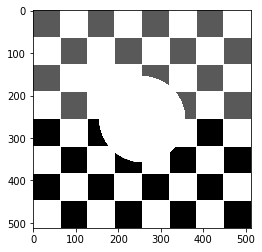

array([[  40.,   60.,   60., ..., 1440., 1440.,  960.],
       [  60.,   90.,   90., ..., 2160., 2160., 1440.],
       [  60.,   90.,   90., ..., 2160., 2160., 1440.],
       ...,
       [1380., 2070., 2070., ...,    0.,    0.,    0.],
       [1380., 2070., 2070., ...,    0.,    0.,    0.],
       [ 920., 1380., 1380., ...,    0.,    0.,    0.]])

In [9]:
image_conv = conv_2d(image,horizontal_edge,mode='zero')
plt.imshow(image_conv,cmap='gray', vmin=0, vmax=255)
plt.show()
image_conv

In [121]:
a = np.array([[1,1],[1,1],[1,1]])
b =  np.array([[2,2],[2,2],[3,3]])

a*b

In [26]:
def denoise_gaussian(image, sigma = 1.0):
   ##########################################################################
   # TODO: YOUR CODE HERE
    sigma = int(sigma)
    x = gaussian_1d(sigma = sigma )
    gaus_2d = x*(x.transpose())
    img = conv_2d(image,gaus_2d,mode = 'mirror')
    
   ##########################################################################
    return img

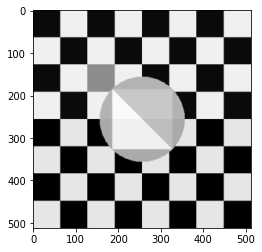

array([[ 10.,  10.,  10., ..., 240., 240., 240.],
       [ 10.,  10.,  10., ..., 240., 240., 240.],
       [ 10.,  10.,  10., ..., 240., 240., 240.],
       ...,
       [230., 230., 230., ...,   0.,   0.,   0.],
       [230., 230., 230., ...,   0.,   0.,   0.],
       [230., 230., 230., ...,   0.,   0.,   0.]])

In [27]:
image_2 = denoise_gaussian(image)
plt.imshow(image_2, cmap='gray', vmin=0, vmax=255)
plt.show()
image_2

In [183]:
def denoise_gaussian(image, sigma = 1.0):
   ##########################################################################
   # TODO: YOUR CODE HERE
    x = gaussian_1d(sigma = sigma )
    gaus_2d = x*(x.transpose())
    return gaus_2d
res = denoise_gaussian(image)
res

array([[1.96412803e-05, 2.39279779e-04, 1.07237757e-03, 1.76805171e-03,
        1.07237757e-03, 2.39279779e-04, 1.96412803e-05],
       [2.39279779e-04, 2.91502447e-03, 1.30642333e-02, 2.15392793e-02,
        1.30642333e-02, 2.91502447e-03, 2.39279779e-04],
       [1.07237757e-03, 1.30642333e-02, 5.85498315e-02, 9.65323526e-02,
        5.85498315e-02, 1.30642333e-02, 1.07237757e-03],
       [1.76805171e-03, 2.15392793e-02, 9.65323526e-02, 1.59154943e-01,
        9.65323526e-02, 2.15392793e-02, 1.76805171e-03],
       [1.07237757e-03, 1.30642333e-02, 5.85498315e-02, 9.65323526e-02,
        5.85498315e-02, 1.30642333e-02, 1.07237757e-03],
       [2.39279779e-04, 2.91502447e-03, 1.30642333e-02, 2.15392793e-02,
        1.30642333e-02, 2.91502447e-03, 2.39279779e-04],
       [1.96412803e-05, 2.39279779e-04, 1.07237757e-03, 1.76805171e-03,
        1.07237757e-03, 2.39279779e-04, 1.96412803e-05]])

In [177]:
x = gaussian_1d(sigma = 1.0)
x*(x.transpose())

array([[1.96519161e-05, 2.39409349e-04, 1.07295826e-03, 1.76900911e-03,
        1.07295826e-03, 2.39409349e-04, 1.96519161e-05],
       [2.39409349e-04, 2.91660295e-03, 1.30713076e-02, 2.15509428e-02,
        1.30713076e-02, 2.91660295e-03, 2.39409349e-04],
       [1.07295826e-03, 1.30713076e-02, 5.85815363e-02, 9.65846250e-02,
        5.85815363e-02, 1.30713076e-02, 1.07295826e-03],
       [1.76900911e-03, 2.15509428e-02, 9.65846250e-02, 1.59241126e-01,
        9.65846250e-02, 2.15509428e-02, 1.76900911e-03],
       [1.07295826e-03, 1.30713076e-02, 5.85815363e-02, 9.65846250e-02,
        5.85815363e-02, 1.30713076e-02, 1.07295826e-03],
       [2.39409349e-04, 2.91660295e-03, 1.30713076e-02, 2.15509428e-02,
        1.30713076e-02, 2.91660295e-03, 2.39409349e-04],
       [1.96519161e-05, 2.39409349e-04, 1.07295826e-03, 1.76900911e-03,
        1.07295826e-03, 2.39409349e-04, 1.96519161e-05]])

In [181]:
def gaussian_1d(sigma = 1.0):
    width = np.ceil(3.0 * sigma)
    x = np.arange(-width, width + 1)
    g = np.exp(-(x**2) / (2 * sigma * sigma))/np.sqrt(2*np.pi*sigma**2)         # normalize filter to sum to 1 ( equivalent
    g = np.atleast_2d(g)       # to multiplication by 1 / sqrt(2*pi*sigma^2) )
    return g
gaussian_1d()plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()

array([[0.00443185, 0.05399097, 0.24197072, 0.39894228, 0.24197072,
        0.05399097, 0.00443185]])

In [8]:
def denoise_median(image, width = 1):
   ##########################################################################
    m = 2*width+1
    
    
    image_h =int(image.shape[0])
    image_w = int(image.shape[1])
    result = np.zeros((image_h,image_w))
    
    for j in range(image_w-m+1):
         for i in range(image_h-m+1):
            temp = []
            for x in range(m):
                for y in range(m):
                    temp.append(image[i+x][j+y])
            median = (np.sort(temp))[int(m*m/2)]
            for x in range(m):
                for y in range(m):
                    result[i+x][j+y] = median
    img = result

   ##  raise NotImplementedError('denoise_median')
   ##########################################################################
    return img

In [133]:
def denoise_median(image, width = 1):
   ##########################################################################
    m = 2*width+1
    image_w =int(image.shape[0])
    image_h = int(image.shape[1])
    result = np.zeros((image_w,image_h))
    for i in range(image_w):
         for j in range(image_h):
                if i>(image_w-width):
                ## the right border
                    right = min(i+width,image_w)
                    left = right - m
                elif i < width:
                    ## the left border
                    left = max(i-width,0)
                    right = left + m
                else:
                    left = i-width
                    right = left +m
                    
                if j > (image_h - width):
                    ## the bottom
                    bottom = min(j+width,image_h)
                    top  = bottom - m
                elif j < width:
                    top = max(j-width,0)
                    bottom = top + m
                else:
                    top = j-width
                    bottom = top+m
                
                temp = np.sort(image[left:right,top:bottom].flatten())
                print((i,j))
                print(left,right,top,bottom)
                image[i,j] = temp[(len(temp)//2)]
    
    
    return image

In [36]:
def denoise_median(image, width = 1):
   ##########################################################################
   # TODO: YOUR CODE HERE
   # discuss the boundary condition with Cheng Du
   
    [image_w, image_h] = np.shape(image)
    m = 2*width+1
    img = np.zeros((image_w, image_h))
    for i in range(image_w):
        for j in range(image_h):
            if  i+width>image_w:
                right = min(i+width, image_w)
                left = right-m
            elif i-width<0:
                left = max(i-width, 0)
                right = left+m
            else:
                left = i-width
                right = left+m
            if  j+width>image_h:
                bottom = min(j+width, image_h)
                top = bottom-m
            elif j-width <0:
                top = max(j-width, 0)
                bottom = top+m
            else:
                top = j-width
                bottom = top+m
        
            window = np.sort(image[left:right, top:bottom].flatten())
            img[i, j]= window[int(np.floor(len(window)/2))]
        
        
    return img

In [37]:
result = denoise_median(image, width = 1)

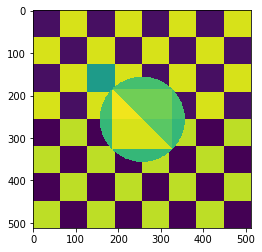

In [38]:
plt.imshow(result, vmin=0, vmax=255)
plt.show()

In [381]:
(image[318:321,478:481])

Array([[ 0.     , 23.9259 , 23.15394],
       [ 7.11242,  6.81348,  7.11242],
       [11.27116,  0.     , 11.15714]])

In [386]:
image[319][480]

7.11242

In [10]:

def sobel_gradients(image):
   ##########################################################################
   # TODO: YOUR CODE HERE
    dx_filter = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    dy_filter = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    dx = conv_2d(image,dx_filter, mode='mirror')
    dy = conv_2d(image,dy_filter,mode='mirror')
   ##########################################################################

    return dx, dy


In [16]:
from PIL import Image
Img = Image.fromarray(sobel)
Img.show()

In [15]:
sobel = sobel_gradients(image)[1]

sobel

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
def direction(image):
    x,y = sobel_gradients(image)
    mag = np.sqrt(x**2+y**2)
    direction = (180*np.arctan(y/x))/math.pi
    direction += 180
    return direction,mag

def nonmax_suppress(mag, theta):
   ##########################################################################
   # TODO: YOUR CODE HERE
    m = len(mag)
    n = len(mag[1])
    mask = mag
    for i in range(1,m-1):
        for j in range(1,n-1):
            angle = theta[i][j]
    ## vertical
            if (angle>67.5 and angle<=112.5) or (angle>=247.5 and angle<=292.5): 
                if (mag[i-1][j])> mag[i][j] or (mag[i+1][j]> mag[i][j]):
                    mask[i][j]=0

    ## horizontal
            elif (angle>340 and angle<=22.5) or (angle>157.5 and angle<=202.5): 
                if ((mag[i][j+1])>mag[i][j] or (mag[i][j-1]> mag[i][j])):
                    mask[i][j]=0

    ## 45
            elif (angle>22.5 and angle<=67.5) or (angle > 202.5 and angle<247.5): 
                if (mag[i-1][j-1]>mag[i][j] or (mag[i+1][j+1]> mag[i][j])):
                    mask[i][j]=0

    ## 135
            else:
                if ((mag[i-1][j+1])>mag[i][j] or (mag[i+1][j-1]> mag[i][j])):
                    
                    mask[i][j]=0

    nonmax = mask
   ##########################################################################
    return nonmax

In [119]:
import math
theta,mag = direction(image)

nonmax = nonmax_suppress(mag,theta)

C:\Users\nian yi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\nian yi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\nian yi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arctan
  after removing the cwd from sys.path.


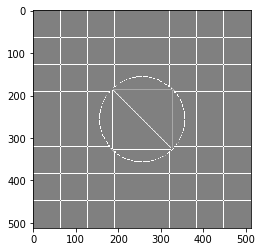

In [120]:
plt.imshow(nonmax, cmap = 'gray' ,vmin=-255, vmax=255)
plt.show()

To track theses edges, we
   investigate the 8 neighbours of strong edges.  Once we find the weak edges,
   located along strong edges' gradient direction, we will mark them as strong
   edges.  You can adopt the same gradient checking strategy used in nonmaximum
   suppression.  This process repeats util we check all strong edges.

   In practice, we use a queue to implement edge linking.  In python, we could
   use a list and its fuction .append or .pop to enqueue or dequeue.
   
   
   
   
   
   1. first compute the low threshold and high threshold so that any pixel below
   low threshold will be thrown away, and any pixel above high threshold is
   a strong edge and will be preserved in the final edge map.
   
   
   2. The pixels that
   fall in-between are considered as weak edges.  We then add weak edges to
   true edges if they connect to a strong edge along the gradient direction.
   
   
   
   
   


In [113]:
def threshold(image, lowRatio=0.01, highRatio=0.05,weak = 25,strong= 250):
    high = image.max() * highRatio;
    low = high*lowRatio;
    m, n = image.shape
    threshold = np.zeros((m,n),dtype = float)
    s_i, s_j = np.where(image >= high)
    w_i, w_j = np.where((image <= high) & (image >= low))
    threshold[s_i, s_j] = strong
    threshold[w_i, w_j] = weak
    
    return threshold,weak,strong

In [114]:
thre = threshold(nonmax)[0]

In [112]:
thre

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

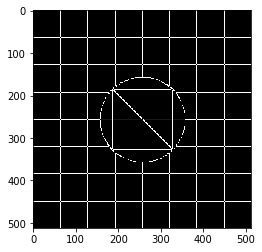

In [115]:
plt.imshow(thre,cmap='gray')
plt.show()

In [101]:
def threshold(image, lowRatio=0.015, highRatio=0.05,weak = 25,strong= 250):
    high = image.max() * highRatio;
    low = high*lowRatio;
    m, n = image.shape
    threshold = np.zeros((m,n),dtype = float)
    s_i, s_j = np.where(image >= high)
    w_i, w_j = np.where((image <= high) & (image >= low))
    threshold[s_i, s_j] = strong
    threshold[w_i, w_j] = weak
    
    return threshold,weak,strong

########################################################################
def helper_checker(angle,nonmax,direction,i,j,strong,weak):
    ## vertical
    if (angle>67.5 and angle<=112.5) or (angle>=247.5 and angle<=292.5):                     
        if (nonmax[i-1][j] == strong or nonmax[i+1][j] == strong):
            direction[i][j] = strong
        else:
            direction[i][j] = 0

    ## horizontal
    if (angle>340 and angle<=22.5) or (angle>157.5 and angle<=202.5): 

        if (nonmax[i][j-1] == strong or nonmax[i][j+1] == strong):
            direction[i][j] = strong
        else:
            direction[i][j] = 0

    ## 45
    if (angle>22.5 and angle<=67.5) or (angle > 202.5 and angle<247.5):

        if (nonmax[i-1][j+1] == strong or nonmax[i+1][j-1] == strong):
            direction[i][j] = strong
        else:  
            direction[i][j] = 0
    ## 135
    else:
        if (nonmax[i+1][j-1] == strong or nonmax[i-1][j+1] == strong):
            direction[i][j] = strong
        else:
            direction[i][j] = 0
    return direction


############################################################################

def hysteresis_edge_linking(nonmax, theta):
    ##########################################################################
    # TODO: YOUR CODE HERE
    row,col = nonmax.shape
    threshold1,weak,strong = threshold(nonmax)
    lefttop = threshold1.copy()
    for i in range(1,row-1):
        for j in range(1,col-1):
            angle = theta[i][j]
            if lefttop[i][j] == weak:
                lefttop = helper_checker(angle,threshold1,lefttop,i,j,strong,weak)
                
     ## bottomright
    bottomright = threshold1.copy()
    for i in range(row-1,1):
        for j in range(col-1,1):
            angle = theta[i][j]
        else:
            direction[i][j] = 0
            if bottomright[i][j] == weak:
                 bottomright = helper_checker(angle,threshold1,bottomright,i,j,strong,weak)
                    
    
     ## bottomleft
    bottomleft = threshold1.copy()
    for i in range(row-1,1):
        for j in range(1,col-1):
            angle = theta[i][j]
            if bottomleft[i][j] == weak:
                 bottomleft = helper_checker(angle,threshold1,bottomleft,i,j,strong,weak)
    print(bottomleft - threshold1)
     ## topright
    topright = threshold1.copy()
    for i in range(1,row-1):
        for j in range(col-1,1):
            angle = theta[i][j]
            if topright[i][j] == weak:
                topright = helper_checker(angle,threshold1,topright,i,j,strong,weak)
            
    edge = lefttop+bottomright+bottomleft+topright
    edge[edge>=strong] = strong
    edge[edge < strong] = 0
                    
    ##raise NotImplementedError('hysteresis_edge_linking')
    ##########################################################################
    return edge

In [116]:
def threshold(image, lowRatio=0.005, highRatio=0.05,weak = 25,strong= 250):
    high = image.max() * highRatio;
    low = high*lowRatio;
    m, n = image.shape
    threshold = np.zeros((m,n),dtype = float)
    s_i, s_j = np.where(image >= high)
    w_i, w_j = np.where((image <= high) & (image >= low))
    threshold[s_i, s_j] = strong
    threshold[w_i, w_j] = weak
    
    return threshold,weak,strong

########################################################################
def helper_checker(angle,nonmax,direction,i,j,strong,weak):
    ## vertical
    if (angle>67.5 and angle<=112.5):
        if nonmax[i-1][j] > 0:
            direction[i-1][j] = strong
    if (angle>=247.5 and angle<=292.5):
        if nonmax[i+1][j] > 0:
            direction[i+1][j] = strong

    ## horizontal
    if (angle>340 and angle<=22.5):
        if nonmax[i][j-1] > 0:
            direction[i][j-1] = strong
    if (angle>157.5 and angle<=202.5):
        if nonmax[i][j+1] > 0:
            direction[i][j+1] = strong

    ## 45
    if (angle>22.5 and angle<=67.5):
        if nonmax[i-1][j+1] > 0:
            direction[i-1][j+1] = strong
    if (angle > 202.5 and angle<247.5):
        if nonmax[i+1][j-1] > 0:
            direction[i+1][j-1] = strong

    ## 135
    if (angle >112.5 and angle<=157.5):
        if nonmax[i-1][j-1] > 0:
            direction[i-1][j-1] = strong
    else:
        if nonmax[i+1][j+1] > 0:
            direction[i+1][j+1] = strong
    return direction


############################################################################
    print(edge-threshold1)
def hysteresis_edge_linking(nonmax, theta):
    ##########################################################################
    # TODO: YOUR CODE HERE
    row,col = nonmax.shape
    threshold1,weak,strong = threshold(nonmax)
    lefttop = threshold1.copy()
    for i in range(1,row-1):
        for j in range(1,col-1):
            angle = theta[i][j]
            if lefttop[i][j] == strong:
                lefttop = helper_checker(angle,threshold1,lefttop,i,j,strong,weak)
                
     ## bottomright
    bottomright = threshold1.copy()
    for i in range(row-1,1):
        for j in range(col-1,1):
            angle = theta[i][j]
            if bottomright[i][j] == strong:
                 bottomright = helper_checker(angle,threshold1,bottomright,i,j,strong,weak)
                    
    
     ## bottomleft
    bottomleft = threshold1.copy()
    for i in range(row-1,1):
        for j in range(1,col-1):
            angle = theta[i][j]
            if bottomleft[i][j] == strong:
                 bottomleft = helper_checker(angle,threshold1,bottomleft,i,j,strong,weak)
                    
     ## topright
    topright = threshold1.copy()
    for i in range(1,row-1):
        for j in range(col-1,1):
            angle = theta[i][j]
            if topright[i][j] == strong:
                topright = helper_checker(angle,threshold1,topright,i,j,strong,weak)
            
    edge = lefttop+bottomright+bottomleft+topright
    edge[edge>=strong] = strong
    edge[edge < strong] = 0
     
                    
    ##raise NotImplementedError('hysteresis_edge_linking')
    ##########################################################################
    return edge

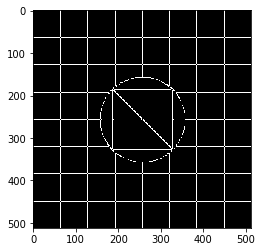

In [117]:
hys = hysteresis_edge_linking(nonmax, theta)
plt.imshow(hys,cmap='gray')
plt.show()

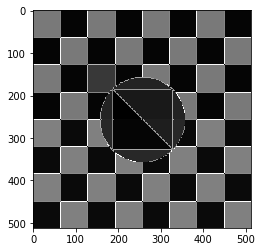

In [118]:
test = hys - image
plt.imshow(test,cmap='gray')
plt.show()

In [504]:
def canny(image):
   ##########################################################################
   # TODO: YOUR CODE HERE
   ## raise NotImplementedError('canny')
   ##########################################################################
# see the direction function:(1) Compute gradients in x- and y-directions at every location using the
#  Sobel operator.  See sobel_gradients() above.
# (2) Estimate edge strength (gradient magnitude) and direction.  
    theta,mag = direction(image)
    
# (3) Perform nonmaximum suppression of the edge strength map, thinning it
# in the direction perpendicular to that of a local edge.
    nonmax = nonmax_suppress(mag,theta)
    
# (4) Compute the high threshold and low threshold of edge strength map
#  to classify the pixels as strong edges, weak edges and non edges.
#  Then link weak edges to strong edges
    edge = hysteresis_edge_linking(nonmax, theta)
    return mag, nonmax, edge

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


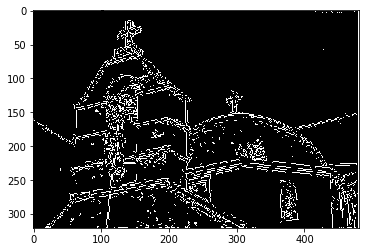

In [505]:
res = canny(image)[2]
plt.imshow(res,cmap='gray')
plt.show()

In [85]:
def denoise_bilateral(image, sigma_s=1, sigma_r=25.5):
    assert image.ndim == 2, 'image should be grayscale'
    ##########################################################################
    # TODO: YOUR CODE HERE
    img = np.zeros(image.shape)
    filter_width = int(np.ceil(3.0 * sigma_s))
    for i in range(len(image)):
        for j in range(len(image[0])):
            bilateral_filter(img,image,filter_width,i,j,sigma_s,sigma_r)
    ##########################################################################
    return img


def gaussian(x, sigma):
    return (1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2))

In [102]:
def bilateral_filter(res,image,filter_width,x,y,sigma_s,sigma_r):
    temp= Wp= 0
    m = 2*filter_width + 1
    for i in range(filter_width,m):
        for j in range(filter_width,m):
            x_left = x+i-filter_width
            y_left = y+j-filter_width          
            if x_left >= len(image):
                x_left = len(image)-1
            if y_left>= len(image[0]):
                y_left = len(image[0])-1
            gi = gaussian(image[x_left][y_left] - image[x][y], sigma_r)
            gs = gaussian((np.sqrt((x_left-x)**2+(y_left-y)**2)), sigma_s)
            temp += image[x_left][y_left] * gi * gs
            Wp += gi * gs
    res[x][y] = temp / Wp

0 0 318 321
0 1 318 321
0 2 318 321
0 3 318 321
0 0 319 321
0 0 319 322
0 1 319 321
0 1 319 322
0 2 319 321
0 2 319 322
0 3 319 321
0 3 319 322
0 0 320 321
0 0 320 322
0 0 320 323
0 1 320 321
0 1 320 322
0 1 320 323
0 2 320 321
0 2 320 322
0 2 320 323
0 3 320 321
0 3 320 322
0 3 320 323
1 1 318 321
1 2 318 321
1 3 318 321
1 4 318 321
1 1 319 321
1 1 319 322
1 2 319 321
1 2 319 322
1 3 319 321
1 3 319 322
1 4 319 321
1 4 319 322
1 1 320 321
1 1 320 322
1 1 320 323
1 2 320 321
1 2 320 322
1 2 320 323
1 3 320 321
1 3 320 322
1 3 320 323
1 4 320 321
1 4 320 322
1 4 320 323
2 2 318 321
2 3 318 321
2 4 318 321
2 5 318 321
2 2 319 321
2 2 319 322
2 3 319 321
2 3 319 322
2 4 319 321
2 4 319 322
2 5 319 321
2 5 319 322
2 2 320 321
2 2 320 322
2 2 320 323
2 3 320 321
2 3 320 322
2 3 320 323
2 4 320 321
2 4 320 322
2 4 320 323
2 5 320 321
2 5 320 322
2 5 320 323
3 3 318 321
3 4 318 321
3 5 318 321
3 6 318 321
3 3 319 321
3 3 319 322
3 4 319 321
3 4 319 322
3 5 319 321
3 5 319 322
3 6 319 321
3 6 

27 27 318 321
27 28 318 321
27 29 318 321
27 30 318 321
27 27 319 321
27 27 319 322
27 28 319 321
27 28 319 322
27 29 319 321
27 29 319 322
27 30 319 321
27 30 319 322
27 27 320 321
27 27 320 322
27 27 320 323
27 28 320 321
27 28 320 322
27 28 320 323
27 29 320 321
27 29 320 322
27 29 320 323
27 30 320 321
27 30 320 322
27 30 320 323
28 28 318 321
28 29 318 321
28 30 318 321
28 31 318 321
28 28 319 321
28 28 319 322
28 29 319 321
28 29 319 322
28 30 319 321
28 30 319 322
28 31 319 321
28 31 319 322
28 28 320 321
28 28 320 322
28 28 320 323
28 29 320 321
28 29 320 322
28 29 320 323
28 30 320 321
28 30 320 322
28 30 320 323
28 31 320 321
28 31 320 322
28 31 320 323
29 29 318 321
29 30 318 321
29 31 318 321
29 32 318 321
29 29 319 321
29 29 319 322
29 30 319 321
29 30 319 322
29 31 319 321
29 31 319 322
29 32 319 321
29 32 319 322
29 29 320 321
29 29 320 322
29 29 320 323
29 30 320 321
29 30 320 322
29 30 320 323
29 31 320 321
29 31 320 322
29 31 320 323
29 32 320 321
29 32 320 322
29 32 

52 52 318 321
52 53 318 321
52 54 318 321
52 55 318 321
52 52 319 321
52 52 319 322
52 53 319 321
52 53 319 322
52 54 319 321
52 54 319 322
52 55 319 321
52 55 319 322
52 52 320 321
52 52 320 322
52 52 320 323
52 53 320 321
52 53 320 322
52 53 320 323
52 54 320 321
52 54 320 322
52 54 320 323
52 55 320 321
52 55 320 322
52 55 320 323
53 53 318 321
53 54 318 321
53 55 318 321
53 56 318 321
53 53 319 321
53 53 319 322
53 54 319 321
53 54 319 322
53 55 319 321
53 55 319 322
53 56 319 321
53 56 319 322
53 53 320 321
53 53 320 322
53 53 320 323
53 54 320 321
53 54 320 322
53 54 320 323
53 55 320 321
53 55 320 322
53 55 320 323
53 56 320 321
53 56 320 322
53 56 320 323
54 54 318 321
54 55 318 321
54 56 318 321
54 57 318 321
54 54 319 321
54 54 319 322
54 55 319 321
54 55 319 322
54 56 319 321
54 56 319 322
54 57 319 321
54 57 319 322
54 54 320 321
54 54 320 322
54 54 320 323
54 55 320 321
54 55 320 322
54 55 320 323
54 56 320 321
54 56 320 322
54 56 320 323
54 57 320 321
54 57 320 322
54 57 

79 79 318 321
79 80 318 321
79 81 318 321
79 82 318 321
79 79 319 321
79 79 319 322
79 80 319 321
79 80 319 322
79 81 319 321
79 81 319 322
79 82 319 321
79 82 319 322
79 79 320 321
79 79 320 322
79 79 320 323
79 80 320 321
79 80 320 322
79 80 320 323
79 81 320 321
79 81 320 322
79 81 320 323
79 82 320 321
79 82 320 322
79 82 320 323
80 80 318 321
80 81 318 321
80 82 318 321
80 83 318 321
80 80 319 321
80 80 319 322
80 81 319 321
80 81 319 322
80 82 319 321
80 82 319 322
80 83 319 321
80 83 319 322
80 80 320 321
80 80 320 322
80 80 320 323
80 81 320 321
80 81 320 322
80 81 320 323
80 82 320 321
80 82 320 322
80 82 320 323
80 83 320 321
80 83 320 322
80 83 320 323
81 81 318 321
81 82 318 321
81 83 318 321
81 84 318 321
81 81 319 321
81 81 319 322
81 82 319 321
81 82 319 322
81 83 319 321
81 83 319 322
81 84 319 321
81 84 319 322
81 81 320 321
81 81 320 322
81 81 320 323
81 82 320 321
81 82 320 322
81 82 320 323
81 83 320 321
81 83 320 322
81 83 320 323
81 84 320 321
81 84 320 322
81 84 

103 103 318 321
103 104 318 321
103 105 318 321
103 106 318 321
103 103 319 321
103 103 319 322
103 104 319 321
103 104 319 322
103 105 319 321
103 105 319 322
103 106 319 321
103 106 319 322
103 103 320 321
103 103 320 322
103 103 320 323
103 104 320 321
103 104 320 322
103 104 320 323
103 105 320 321
103 105 320 322
103 105 320 323
103 106 320 321
103 106 320 322
103 106 320 323
104 104 318 321
104 105 318 321
104 106 318 321
104 107 318 321
104 104 319 321
104 104 319 322
104 105 319 321
104 105 319 322
104 106 319 321
104 106 319 322
104 107 319 321
104 107 319 322
104 104 320 321
104 104 320 322
104 104 320 323
104 105 320 321
104 105 320 322
104 105 320 323
104 106 320 321
104 106 320 322
104 106 320 323
104 107 320 321
104 107 320 322
104 107 320 323
105 105 318 321
105 106 318 321
105 107 318 321
105 108 318 321
105 105 319 321
105 105 319 322
105 106 319 321
105 106 319 322
105 107 319 321
105 107 319 322
105 108 319 321
105 108 319 322
105 105 320 321
105 105 320 322
105 105 

128 128 318 321
128 129 318 321
128 130 318 321
128 131 318 321
128 128 319 321
128 128 319 322
128 129 319 321
128 129 319 322
128 130 319 321
128 130 319 322
128 131 319 321
128 131 319 322
128 128 320 321
128 128 320 322
128 128 320 323
128 129 320 321
128 129 320 322
128 129 320 323
128 130 320 321
128 130 320 322
128 130 320 323
128 131 320 321
128 131 320 322
128 131 320 323
129 129 318 321
129 130 318 321
129 131 318 321
129 132 318 321
129 129 319 321
129 129 319 322
129 130 319 321
129 130 319 322
129 131 319 321
129 131 319 322
129 132 319 321
129 132 319 322
129 129 320 321
129 129 320 322
129 129 320 323
129 130 320 321
129 130 320 322
129 130 320 323
129 131 320 321
129 131 320 322
129 131 320 323
129 132 320 321
129 132 320 322
129 132 320 323
130 130 318 321
130 131 318 321
130 132 318 321
130 133 318 321
130 130 319 321
130 130 319 322
130 131 319 321
130 131 319 322
130 132 319 321
130 132 319 322
130 133 319 321
130 133 319 322
130 130 320 321
130 130 320 322
130 130 

150 150 318 321
150 151 318 321
150 152 318 321
150 153 318 321
150 150 319 321
150 150 319 322
150 151 319 321
150 151 319 322
150 152 319 321
150 152 319 322
150 153 319 321
150 153 319 322
150 150 320 321
150 150 320 322
150 150 320 323
150 151 320 321
150 151 320 322
150 151 320 323
150 152 320 321
150 152 320 322
150 152 320 323
150 153 320 321
150 153 320 322
150 153 320 323
151 151 318 321
151 152 318 321
151 153 318 321
151 154 318 321
151 151 319 321
151 151 319 322
151 152 319 321
151 152 319 322
151 153 319 321
151 153 319 322
151 154 319 321
151 154 319 322
151 151 320 321
151 151 320 322
151 151 320 323
151 152 320 321
151 152 320 322
151 152 320 323
151 153 320 321
151 153 320 322
151 153 320 323
151 154 320 321
151 154 320 322
151 154 320 323
152 152 318 321
152 153 318 321
152 154 318 321
152 155 318 321
152 152 319 321
152 152 319 322
152 153 319 321
152 153 319 322
152 154 319 321
152 154 319 322
152 155 319 321
152 155 319 322
152 152 320 321
152 152 320 322
152 152 

172 172 318 321
172 173 318 321
172 174 318 321
172 175 318 321
172 172 319 321
172 172 319 322
172 173 319 321
172 173 319 322
172 174 319 321
172 174 319 322
172 175 319 321
172 175 319 322
172 172 320 321
172 172 320 322
172 172 320 323
172 173 320 321
172 173 320 322
172 173 320 323
172 174 320 321
172 174 320 322
172 174 320 323
172 175 320 321
172 175 320 322
172 175 320 323
173 173 318 321
173 174 318 321
173 175 318 321
173 176 318 321
173 173 319 321
173 173 319 322
173 174 319 321
173 174 319 322
173 175 319 321
173 175 319 322
173 176 319 321
173 176 319 322
173 173 320 321
173 173 320 322
173 173 320 323
173 174 320 321
173 174 320 322
173 174 320 323
173 175 320 321
173 175 320 322
173 175 320 323
173 176 320 321
173 176 320 322
173 176 320 323
174 174 318 321
174 175 318 321
174 176 318 321
174 177 318 321
174 174 319 321
174 174 319 322
174 175 319 321
174 175 319 322
174 176 319 321
174 176 319 322
174 177 319 321
174 177 319 322
174 174 320 321
174 174 320 322
174 174 

195 195 318 321
195 196 318 321
195 197 318 321
195 198 318 321
195 195 319 321
195 195 319 322
195 196 319 321
195 196 319 322
195 197 319 321
195 197 319 322
195 198 319 321
195 198 319 322
195 195 320 321
195 195 320 322
195 195 320 323
195 196 320 321
195 196 320 322
195 196 320 323
195 197 320 321
195 197 320 322
195 197 320 323
195 198 320 321
195 198 320 322
195 198 320 323
196 196 318 321
196 197 318 321
196 198 318 321
196 199 318 321
196 196 319 321
196 196 319 322
196 197 319 321
196 197 319 322
196 198 319 321
196 198 319 322
196 199 319 321
196 199 319 322
196 196 320 321
196 196 320 322
196 196 320 323
196 197 320 321
196 197 320 322
196 197 320 323
196 198 320 321
196 198 320 322
196 198 320 323
196 199 320 321
196 199 320 322
196 199 320 323
197 197 318 321
197 198 318 321
197 199 318 321
197 200 318 321
197 197 319 321
197 197 319 322
197 198 319 321
197 198 319 322
197 199 319 321
197 199 319 322
197 200 319 321
197 200 319 322
197 197 320 321
197 197 320 322
197 197 

219 219 318 321
219 220 318 321
219 221 318 321
219 222 318 321
219 219 319 321
219 219 319 322
219 220 319 321
219 220 319 322
219 221 319 321
219 221 319 322
219 222 319 321
219 222 319 322
219 219 320 321
219 219 320 322
219 219 320 323
219 220 320 321
219 220 320 322
219 220 320 323
219 221 320 321
219 221 320 322
219 221 320 323
219 222 320 321
219 222 320 322
219 222 320 323
220 220 318 321
220 221 318 321
220 222 318 321
220 223 318 321
220 220 319 321
220 220 319 322
220 221 319 321
220 221 319 322
220 222 319 321
220 222 319 322
220 223 319 321
220 223 319 322
220 220 320 321
220 220 320 322
220 220 320 323
220 221 320 321
220 221 320 322
220 221 320 323
220 222 320 321
220 222 320 322
220 222 320 323
220 223 320 321
220 223 320 322
220 223 320 323
221 221 318 321
221 222 318 321
221 223 318 321
221 224 318 321
221 221 319 321
221 221 319 322
221 222 319 321
221 222 319 322
221 223 319 321
221 223 319 322
221 224 319 321
221 224 319 322
221 221 320 321
221 221 320 322
221 221 

243 243 318 321
243 244 318 321
243 245 318 321
243 246 318 321
243 243 319 321
243 243 319 322
243 244 319 321
243 244 319 322
243 245 319 321
243 245 319 322
243 246 319 321
243 246 319 322
243 243 320 321
243 243 320 322
243 243 320 323
243 244 320 321
243 244 320 322
243 244 320 323
243 245 320 321
243 245 320 322
243 245 320 323
243 246 320 321
243 246 320 322
243 246 320 323
244 244 318 321
244 245 318 321
244 246 318 321
244 247 318 321
244 244 319 321
244 244 319 322
244 245 319 321
244 245 319 322
244 246 319 321
244 246 319 322
244 247 319 321
244 247 319 322
244 244 320 321
244 244 320 322
244 244 320 323
244 245 320 321
244 245 320 322
244 245 320 323
244 246 320 321
244 246 320 322
244 246 320 323
244 247 320 321
244 247 320 322
244 247 320 323
245 245 318 321
245 246 318 321
245 247 318 321
245 248 318 321
245 245 319 321
245 245 319 322
245 246 319 321
245 246 319 322
245 247 319 321
245 247 319 322
245 248 319 321
245 248 319 322
245 245 320 321
245 245 320 322
245 245 

267 267 318 321
267 268 318 321
267 269 318 321
267 270 318 321
267 267 319 321
267 267 319 322
267 268 319 321
267 268 319 322
267 269 319 321
267 269 319 322
267 270 319 321
267 270 319 322
267 267 320 321
267 267 320 322
267 267 320 323
267 268 320 321
267 268 320 322
267 268 320 323
267 269 320 321
267 269 320 322
267 269 320 323
267 270 320 321
267 270 320 322
267 270 320 323
268 268 318 321
268 269 318 321
268 270 318 321
268 271 318 321
268 268 319 321
268 268 319 322
268 269 319 321
268 269 319 322
268 270 319 321
268 270 319 322
268 271 319 321
268 271 319 322
268 268 320 321
268 268 320 322
268 268 320 323
268 269 320 321
268 269 320 322
268 269 320 323
268 270 320 321
268 270 320 322
268 270 320 323
268 271 320 321
268 271 320 322
268 271 320 323
269 269 318 321
269 270 318 321
269 271 318 321
269 272 318 321
269 269 319 321
269 269 319 322
269 270 319 321
269 270 319 322
269 271 319 321
269 271 319 322
269 272 319 321
269 272 319 322
269 269 320 321
269 269 320 322
269 269 

290 290 318 321
290 291 318 321
290 292 318 321
290 293 318 321
290 290 319 321
290 290 319 322
290 291 319 321
290 291 319 322
290 292 319 321
290 292 319 322
290 293 319 321
290 293 319 322
290 290 320 321
290 290 320 322
290 290 320 323
290 291 320 321
290 291 320 322
290 291 320 323
290 292 320 321
290 292 320 322
290 292 320 323
290 293 320 321
290 293 320 322
290 293 320 323
291 291 318 321
291 292 318 321
291 293 318 321
291 294 318 321
291 291 319 321
291 291 319 322
291 292 319 321
291 292 319 322
291 293 319 321
291 293 319 322
291 294 319 321
291 294 319 322
291 291 320 321
291 291 320 322
291 291 320 323
291 292 320 321
291 292 320 322
291 292 320 323
291 293 320 321
291 293 320 322
291 293 320 323
291 294 320 321
291 294 320 322
291 294 320 323
292 292 318 321
292 293 318 321
292 294 318 321
292 295 318 321
292 292 319 321
292 292 319 322
292 293 319 321
292 293 319 322
292 294 319 321
292 294 319 322
292 295 319 321
292 295 319 322
292 292 320 321
292 292 320 322
292 292 

314 314 318 321
314 315 318 321
314 316 318 321
314 317 318 321
314 314 319 321
314 314 319 322
314 315 319 321
314 315 319 322
314 316 319 321
314 316 319 322
314 317 319 321
314 317 319 322
314 314 320 321
314 314 320 322
314 314 320 323
314 315 320 321
314 315 320 322
314 315 320 323
314 316 320 321
314 316 320 322
314 316 320 323
314 317 320 321
314 317 320 322
314 317 320 323
315 315 318 321
315 316 318 321
315 317 318 321
315 318 318 321
315 315 319 321
315 315 319 322
315 316 319 321
315 316 319 322
315 317 319 321
315 317 319 322
315 318 319 321
315 318 319 322
315 315 320 321
315 315 320 322
315 315 320 323
315 316 320 321
315 316 320 322
315 316 320 323
315 317 320 321
315 317 320 322
315 317 320 323
315 318 320 321
315 318 320 322
315 318 320 323
316 316 318 321
316 317 318 321
316 318 318 321
316 319 318 321
316 316 319 321
316 316 319 322
316 317 319 321
316 317 319 322
316 318 319 321
316 318 319 322
316 319 319 321
316 319 319 322
316 316 320 321
316 316 320 322
316 316 

336 336 318 321
336 337 318 321
336 338 318 321
336 339 318 321
336 336 319 321
336 336 319 322
336 337 319 321
336 337 319 322
336 338 319 321
336 338 319 322
336 339 319 321
336 339 319 322
336 336 320 321
336 336 320 322
336 336 320 323
336 337 320 321
336 337 320 322
336 337 320 323
336 338 320 321
336 338 320 322
336 338 320 323
336 339 320 321
336 339 320 322
336 339 320 323
337 337 318 321
337 338 318 321
337 339 318 321
337 340 318 321
337 337 319 321
337 337 319 322
337 338 319 321
337 338 319 322
337 339 319 321
337 339 319 322
337 340 319 321
337 340 319 322
337 337 320 321
337 337 320 322
337 337 320 323
337 338 320 321
337 338 320 322
337 338 320 323
337 339 320 321
337 339 320 322
337 339 320 323
337 340 320 321
337 340 320 322
337 340 320 323
338 338 318 321
338 339 318 321
338 340 318 321
338 341 318 321
338 338 319 321
338 338 319 322
338 339 319 321
338 339 319 322
338 340 319 321
338 340 319 322
338 341 319 321
338 341 319 322
338 338 320 321
338 338 320 322
338 338 

360 360 318 321
360 361 318 321
360 362 318 321
360 363 318 321
360 360 319 321
360 360 319 322
360 361 319 321
360 361 319 322
360 362 319 321
360 362 319 322
360 363 319 321
360 363 319 322
360 360 320 321
360 360 320 322
360 360 320 323
360 361 320 321
360 361 320 322
360 361 320 323
360 362 320 321
360 362 320 322
360 362 320 323
360 363 320 321
360 363 320 322
360 363 320 323
361 361 318 321
361 362 318 321
361 363 318 321
361 364 318 321
361 361 319 321
361 361 319 322
361 362 319 321
361 362 319 322
361 363 319 321
361 363 319 322
361 364 319 321
361 364 319 322
361 361 320 321
361 361 320 322
361 361 320 323
361 362 320 321
361 362 320 322
361 362 320 323
361 363 320 321
361 363 320 322
361 363 320 323
361 364 320 321
361 364 320 322
361 364 320 323
362 362 318 321
362 363 318 321
362 364 318 321
362 365 318 321
362 362 319 321
362 362 319 322
362 363 319 321
362 363 319 322
362 364 319 321
362 364 319 322
362 365 319 321
362 365 319 322
362 362 320 321
362 362 320 322
362 362 

384 384 318 321
384 385 318 321
384 386 318 321
384 387 318 321
384 384 319 321
384 384 319 322
384 385 319 321
384 385 319 322
384 386 319 321
384 386 319 322
384 387 319 321
384 387 319 322
384 384 320 321
384 384 320 322
384 384 320 323
384 385 320 321
384 385 320 322
384 385 320 323
384 386 320 321
384 386 320 322
384 386 320 323
384 387 320 321
384 387 320 322
384 387 320 323
385 385 318 321
385 386 318 321
385 387 318 321
385 388 318 321
385 385 319 321
385 385 319 322
385 386 319 321
385 386 319 322
385 387 319 321
385 387 319 322
385 388 319 321
385 388 319 322
385 385 320 321
385 385 320 322
385 385 320 323
385 386 320 321
385 386 320 322
385 386 320 323
385 387 320 321
385 387 320 322
385 387 320 323
385 388 320 321
385 388 320 322
385 388 320 323
386 386 318 321
386 387 318 321
386 388 318 321
386 389 318 321
386 386 319 321
386 386 319 322
386 387 319 321
386 387 319 322
386 388 319 321
386 388 319 322
386 389 319 321
386 389 319 322
386 386 320 321
386 386 320 322
386 386 

409 409 318 321
409 410 318 321
409 411 318 321
409 412 318 321
409 409 319 321
409 409 319 322
409 410 319 321
409 410 319 322
409 411 319 321
409 411 319 322
409 412 319 321
409 412 319 322
409 409 320 321
409 409 320 322
409 409 320 323
409 410 320 321
409 410 320 322
409 410 320 323
409 411 320 321
409 411 320 322
409 411 320 323
409 412 320 321
409 412 320 322
409 412 320 323
410 410 318 321
410 411 318 321
410 412 318 321
410 413 318 321
410 410 319 321
410 410 319 322
410 411 319 321
410 411 319 322
410 412 319 321
410 412 319 322
410 413 319 321
410 413 319 322
410 410 320 321
410 410 320 322
410 410 320 323
410 411 320 321
410 411 320 322
410 411 320 323
410 412 320 321
410 412 320 322
410 412 320 323
410 413 320 321
410 413 320 322
410 413 320 323
411 411 318 321
411 412 318 321
411 413 318 321
411 414 318 321
411 411 319 321
411 411 319 322
411 412 319 321
411 412 319 322
411 413 319 321
411 413 319 322
411 414 319 321
411 414 319 322
411 411 320 321
411 411 320 322
411 411 

431 431 318 321
431 432 318 321
431 433 318 321
431 434 318 321
431 431 319 321
431 431 319 322
431 432 319 321
431 432 319 322
431 433 319 321
431 433 319 322
431 434 319 321
431 434 319 322
431 431 320 321
431 431 320 322
431 431 320 323
431 432 320 321
431 432 320 322
431 432 320 323
431 433 320 321
431 433 320 322
431 433 320 323
431 434 320 321
431 434 320 322
431 434 320 323
432 432 318 321
432 433 318 321
432 434 318 321
432 435 318 321
432 432 319 321
432 432 319 322
432 433 319 321
432 433 319 322
432 434 319 321
432 434 319 322
432 435 319 321
432 435 319 322
432 432 320 321
432 432 320 322
432 432 320 323
432 433 320 321
432 433 320 322
432 433 320 323
432 434 320 321
432 434 320 322
432 434 320 323
432 435 320 321
432 435 320 322
432 435 320 323
433 433 318 321
433 434 318 321
433 435 318 321
433 436 318 321
433 433 319 321
433 433 319 322
433 434 319 321
433 434 319 322
433 435 319 321
433 435 319 322
433 436 319 321
433 436 319 322
433 433 320 321
433 433 320 322
433 433 

454 454 319 322
454 455 319 321
454 455 319 322
454 456 319 321
454 456 319 322
454 457 319 321
454 457 319 322
454 454 320 321
454 454 320 322
454 454 320 323
454 455 320 321
454 455 320 322
454 455 320 323
454 456 320 321
454 456 320 322
454 456 320 323
454 457 320 321
454 457 320 322
454 457 320 323
455 455 318 321
455 456 318 321
455 457 318 321
455 458 318 321
455 455 319 321
455 455 319 322
455 456 319 321
455 456 319 322
455 457 319 321
455 457 319 322
455 458 319 321
455 458 319 322
455 455 320 321
455 455 320 322
455 455 320 323
455 456 320 321
455 456 320 322
455 456 320 323
455 457 320 321
455 457 320 322
455 457 320 323
455 458 320 321
455 458 320 322
455 458 320 323
456 456 318 321
456 457 318 321
456 458 318 321
456 459 318 321
456 456 319 321
456 456 319 322
456 457 319 321
456 457 319 322
456 458 319 321
456 458 319 322
456 459 319 321
456 459 319 322
456 456 320 321
456 456 320 322
456 456 320 323
456 457 320 321
456 457 320 322
456 457 320 323
456 458 320 321
456 458 

476 476 318 321
476 477 318 321
476 478 318 321
476 479 318 321
476 476 319 321
476 476 319 322
476 477 319 321
476 477 319 322
476 478 319 321
476 478 319 322
476 479 319 321
476 479 319 322
476 476 320 321
476 476 320 322
476 476 320 323
476 477 320 321
476 477 320 322
476 477 320 323
476 478 320 321
476 478 320 322
476 478 320 323
476 479 320 321
476 479 320 322
476 479 320 323
477 477 318 321
477 478 318 321
477 479 318 321
477 480 318 321
477 477 319 321
477 477 319 322
477 478 319 321
477 478 319 322
477 479 319 321
477 479 319 322
477 480 319 321
477 480 319 322
477 477 320 321
477 477 320 322
477 477 320 323
477 478 320 321
477 478 320 322
477 478 320 323
477 479 320 321
477 479 320 322
477 479 320 323
477 480 320 321
477 480 320 322
477 480 320 323
478 481 0 0
478 481 0 1
478 481 0 2
478 481 0 3
478 481 1 1
478 481 1 2
478 481 1 3
478 481 1 4
478 481 2 2
478 481 2 3
478 481 2 4
478 481 2 5
478 481 3 3
478 481 3 4
478 481 3 5
478 481 3 6
478 481 4 4
478 481 4 5
478 481 4 6
478 

478 481 132 132
478 481 132 133
478 481 132 134
478 481 132 135
478 481 133 133
478 481 133 134
478 481 133 135
478 481 133 136
478 481 134 134
478 481 134 135
478 481 134 136
478 481 134 137
478 481 135 135
478 481 135 136
478 481 135 137
478 481 135 138
478 481 136 136
478 481 136 137
478 481 136 138
478 481 136 139
478 481 137 137
478 481 137 138
478 481 137 139
478 481 137 140
478 481 138 138
478 481 138 139
478 481 138 140
478 481 138 141
478 481 139 139
478 481 139 140
478 481 139 141
478 481 139 142
478 481 140 140
478 481 140 141
478 481 140 142
478 481 140 143
478 481 141 141
478 481 141 142
478 481 141 143
478 481 141 144
478 481 142 142
478 481 142 143
478 481 142 144
478 481 142 145
478 481 143 143
478 481 143 144
478 481 143 145
478 481 143 146
478 481 144 144
478 481 144 145
478 481 144 146
478 481 144 147
478 481 145 145
478 481 145 146
478 481 145 147
478 481 145 148
478 481 146 146
478 481 146 147
478 481 146 148
478 481 146 149
478 481 147 147
478 481 147 148
478 481 

478 480 320 323
479 481 0 0
479 481 0 1
479 481 0 2
479 481 0 3
479 482 0 0
479 482 0 1
479 482 0 2
479 482 0 3
479 481 1 1
479 481 1 2
479 481 1 3
479 481 1 4
479 482 1 1
479 482 1 2
479 482 1 3
479 482 1 4
479 481 2 2
479 481 2 3
479 481 2 4
479 481 2 5
479 482 2 2
479 482 2 3
479 482 2 4
479 482 2 5
479 481 3 3
479 481 3 4
479 481 3 5
479 481 3 6
479 482 3 3
479 482 3 4
479 482 3 5
479 482 3 6
479 481 4 4
479 481 4 5
479 481 4 6
479 481 4 7
479 482 4 4
479 482 4 5
479 482 4 6
479 482 4 7
479 481 5 5
479 481 5 6
479 481 5 7
479 481 5 8
479 482 5 5
479 482 5 6
479 482 5 7
479 482 5 8
479 481 6 6
479 481 6 7
479 481 6 8
479 481 6 9
479 482 6 6
479 482 6 7
479 482 6 8
479 482 6 9
479 481 7 7
479 481 7 8
479 481 7 9
479 481 7 10
479 482 7 7
479 482 7 8
479 482 7 9
479 482 7 10
479 481 8 8
479 481 8 9
479 481 8 10
479 481 8 11
479 482 8 8
479 482 8 9
479 482 8 10
479 482 8 11
479 481 9 9
479 481 9 10
479 481 9 11
479 481 9 12
479 482 9 9
479 482 9 10
479 482 9 11
479 482 9 12
479 481 10 1

479 481 92 92
479 481 92 93
479 481 92 94
479 481 92 95
479 482 92 92
479 482 92 93
479 482 92 94
479 482 92 95
479 481 93 93
479 481 93 94
479 481 93 95
479 481 93 96
479 482 93 93
479 482 93 94
479 482 93 95
479 482 93 96
479 481 94 94
479 481 94 95
479 481 94 96
479 481 94 97
479 482 94 94
479 482 94 95
479 482 94 96
479 482 94 97
479 481 95 95
479 481 95 96
479 481 95 97
479 481 95 98
479 482 95 95
479 482 95 96
479 482 95 97
479 482 95 98
479 481 96 96
479 481 96 97
479 481 96 98
479 481 96 99
479 482 96 96
479 482 96 97
479 482 96 98
479 482 96 99
479 481 97 97
479 481 97 98
479 481 97 99
479 481 97 100
479 482 97 97
479 482 97 98
479 482 97 99
479 482 97 100
479 481 98 98
479 481 98 99
479 481 98 100
479 481 98 101
479 482 98 98
479 482 98 99
479 482 98 100
479 482 98 101
479 481 99 99
479 481 99 100
479 481 99 101
479 481 99 102
479 482 99 99
479 482 99 100
479 482 99 101
479 482 99 102
479 481 100 100
479 481 100 101
479 481 100 102
479 481 100 103
479 482 100 100
479 482 100 

479 481 197 197
479 481 197 198
479 481 197 199
479 481 197 200
479 482 197 197
479 482 197 198
479 482 197 199
479 482 197 200
479 481 198 198
479 481 198 199
479 481 198 200
479 481 198 201
479 482 198 198
479 482 198 199
479 482 198 200
479 482 198 201
479 481 199 199
479 481 199 200
479 481 199 201
479 481 199 202
479 482 199 199
479 482 199 200
479 482 199 201
479 482 199 202
479 481 200 200
479 481 200 201
479 481 200 202
479 481 200 203
479 482 200 200
479 482 200 201
479 482 200 202
479 482 200 203
479 481 201 201
479 481 201 202
479 481 201 203
479 481 201 204
479 482 201 201
479 482 201 202
479 482 201 203
479 482 201 204
479 481 202 202
479 481 202 203
479 481 202 204
479 481 202 205
479 482 202 202
479 482 202 203
479 482 202 204
479 482 202 205
479 481 203 203
479 481 203 204
479 481 203 205
479 481 203 206
479 482 203 203
479 482 203 204
479 482 203 205
479 482 203 206
479 481 204 204
479 481 204 205
479 481 204 206
479 481 204 207
479 482 204 204
479 482 204 205
479 482 

479 481 299 300
479 481 299 301
479 481 299 302
479 482 299 299
479 482 299 300
479 482 299 301
479 482 299 302
479 481 300 300
479 481 300 301
479 481 300 302
479 481 300 303
479 482 300 300
479 482 300 301
479 482 300 302
479 482 300 303
479 481 301 301
479 481 301 302
479 481 301 303
479 481 301 304
479 482 301 301
479 482 301 302
479 482 301 303
479 482 301 304
479 481 302 302
479 481 302 303
479 481 302 304
479 481 302 305
479 482 302 302
479 482 302 303
479 482 302 304
479 482 302 305
479 481 303 303
479 481 303 304
479 481 303 305
479 481 303 306
479 482 303 303
479 482 303 304
479 482 303 305
479 482 303 306
479 481 304 304
479 481 304 305
479 481 304 306
479 481 304 307
479 482 304 304
479 482 304 305
479 482 304 306
479 482 304 307
479 481 305 305
479 481 305 306
479 481 305 307
479 481 305 308
479 482 305 305
479 482 305 306
479 482 305 307
479 482 305 308
479 481 306 306
479 481 306 307
479 481 306 308
479 481 306 309
479 482 306 306
479 482 306 307
479 482 306 308
479 482 

480 481 54 55
480 481 54 56
480 481 54 57
480 482 54 54
480 482 54 55
480 482 54 56
480 482 54 57
480 483 54 54
480 483 54 55
480 483 54 56
480 483 54 57
480 481 55 55
480 481 55 56
480 481 55 57
480 481 55 58
480 482 55 55
480 482 55 56
480 482 55 57
480 482 55 58
480 483 55 55
480 483 55 56
480 483 55 57
480 483 55 58
480 481 56 56
480 481 56 57
480 481 56 58
480 481 56 59
480 482 56 56
480 482 56 57
480 482 56 58
480 482 56 59
480 483 56 56
480 483 56 57
480 483 56 58
480 483 56 59
480 481 57 57
480 481 57 58
480 481 57 59
480 481 57 60
480 482 57 57
480 482 57 58
480 482 57 59
480 482 57 60
480 483 57 57
480 483 57 58
480 483 57 59
480 483 57 60
480 481 58 58
480 481 58 59
480 481 58 60
480 481 58 61
480 482 58 58
480 482 58 59
480 482 58 60
480 482 58 61
480 483 58 58
480 483 58 59
480 483 58 60
480 483 58 61
480 481 59 59
480 481 59 60
480 481 59 61
480 481 59 62
480 482 59 59
480 482 59 60
480 482 59 61
480 482 59 62
480 483 59 59
480 483 59 60
480 483 59 61
480 483 59 62
480 48

480 482 122 125
480 483 122 122
480 483 122 123
480 483 122 124
480 483 122 125
480 481 123 123
480 481 123 124
480 481 123 125
480 481 123 126
480 482 123 123
480 482 123 124
480 482 123 125
480 482 123 126
480 483 123 123
480 483 123 124
480 483 123 125
480 483 123 126
480 481 124 124
480 481 124 125
480 481 124 126
480 481 124 127
480 482 124 124
480 482 124 125
480 482 124 126
480 482 124 127
480 483 124 124
480 483 124 125
480 483 124 126
480 483 124 127
480 481 125 125
480 481 125 126
480 481 125 127
480 481 125 128
480 482 125 125
480 482 125 126
480 482 125 127
480 482 125 128
480 483 125 125
480 483 125 126
480 483 125 127
480 483 125 128
480 481 126 126
480 481 126 127
480 481 126 128
480 481 126 129
480 482 126 126
480 482 126 127
480 482 126 128
480 482 126 129
480 483 126 126
480 483 126 127
480 483 126 128
480 483 126 129
480 481 127 127
480 481 127 128
480 481 127 129
480 481 127 130
480 482 127 127
480 482 127 128
480 482 127 129
480 482 127 130
480 483 127 127
480 483 

480 482 195 198
480 483 195 195
480 483 195 196
480 483 195 197
480 483 195 198
480 481 196 196
480 481 196 197
480 481 196 198
480 481 196 199
480 482 196 196
480 482 196 197
480 482 196 198
480 482 196 199
480 483 196 196
480 483 196 197
480 483 196 198
480 483 196 199
480 481 197 197
480 481 197 198
480 481 197 199
480 481 197 200
480 482 197 197
480 482 197 198
480 482 197 199
480 482 197 200
480 483 197 197
480 483 197 198
480 483 197 199
480 483 197 200
480 481 198 198
480 481 198 199
480 481 198 200
480 481 198 201
480 482 198 198
480 482 198 199
480 482 198 200
480 482 198 201
480 483 198 198
480 483 198 199
480 483 198 200
480 483 198 201
480 481 199 199
480 481 199 200
480 481 199 201
480 481 199 202
480 482 199 199
480 482 199 200
480 482 199 201
480 482 199 202
480 483 199 199
480 483 199 200
480 483 199 201
480 483 199 202
480 481 200 200
480 481 200 201
480 481 200 202
480 481 200 203
480 482 200 200
480 482 200 201
480 482 200 202
480 482 200 203
480 483 200 200
480 483 

480 481 258 259
480 481 258 260
480 481 258 261
480 482 258 258
480 482 258 259
480 482 258 260
480 482 258 261
480 483 258 258
480 483 258 259
480 483 258 260
480 483 258 261
480 481 259 259
480 481 259 260
480 481 259 261
480 481 259 262
480 482 259 259
480 482 259 260
480 482 259 261
480 482 259 262
480 483 259 259
480 483 259 260
480 483 259 261
480 483 259 262
480 481 260 260
480 481 260 261
480 481 260 262
480 481 260 263
480 482 260 260
480 482 260 261
480 482 260 262
480 482 260 263
480 483 260 260
480 483 260 261
480 483 260 262
480 483 260 263
480 481 261 261
480 481 261 262
480 481 261 263
480 481 261 264
480 482 261 261
480 482 261 262
480 482 261 263
480 482 261 264
480 483 261 261
480 483 261 262
480 483 261 263
480 483 261 264
480 481 262 262
480 481 262 263
480 481 262 264
480 481 262 265
480 482 262 262
480 482 262 263
480 482 262 264
480 482 262 265
480 483 262 262
480 483 262 263
480 483 262 264
480 483 262 265
480 481 263 263
480 481 263 264
480 481 263 265
480 481 

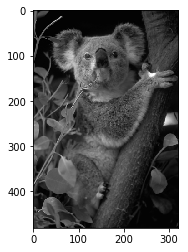

In [103]:
res = denoise_bilateral(image, sigma_s=1, sigma_r=25.5)
plt.imshow(res,cmap='gray')
plt.show()

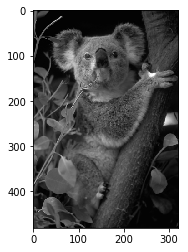

In [104]:
plt.imshow(res,cmap='gray')
plt.show()

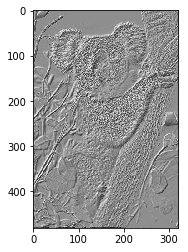

In [105]:
test = (res - image)

plt.imshow(test,cmap='gray')
plt.show()

In [1]:
import sys
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def is_same(im1, im2, eps=0.01):
    return np.sum(np.abs(im1 - im2) / np.prod(im1.shape)) <= eps

def print_res_match(im1, im2, eps=0.01):
    print('Result Match = ' + str(is_same(im1, im2, eps)))

def print_shape_match(im1, im2):
    print('Shape Match = ' + str(im1.shape == im2.shape))

# import the reference code (master solution)
# and the student's code

In [122]:

print('Testing Linear:')
# initialize Linear
student_linear = Linear(30, 10)
ref_linear = nn.Linear(30, 10, bias=True)
# align input data
linear_data_pt = Variable(torch.rand(1, 30), requires_grad = True)
linear_data_numpy = linear_data_pt.data.numpy()
# align weight and bias
# NOTE: Use transpose is because the slight shape definition difference between PyNet and Pytorch.
ref_linear.weight.data = torch.from_numpy(student_linear.weight.transpose().astype(np.float32)).clone().detach().requires_grad_(True)
ref_linear.bias.data = torch.from_numpy(student_linear.bias.transpose().astype(np.float32)).clone().detach().requires_grad_(True)
# check output

ref_out = ref_linear(linear_data_pt)
student_out = student_linear.forward(linear_data_numpy)


print_shape_match(ref_out.data.numpy(), student_out)

print_res_match(ref_out.data.numpy(), student_out)

# check gradients




grad_out, grad_w, grad_b = student_linear.backward(np.ones_like(student_out))

ref_out.backward(torch.ones_like(ref_out))

print(np.shape(grad_out))

print(np.shape(linear_data_pt.grad.data.numpy()))

print_res_match(linear_data_pt.grad.data.numpy(), grad_out)





print_res_match(ref_linear.weight.grad.data.numpy().transpose(), grad_w)
print_res_match(ref_linear.bias.grad.data.numpy().transpose(), grad_b)
print('\n')

Testing Linear:
Shape Match = True
Result Match = True
(1, 30) (1, 10)
(1, 30)
(1, 30)
Result Match = True
Result Match = True
Result Match = True




In [1]:
import numpy as np
from math import *

'''
    Linear

    Implementation of the linear layer (also called fully connected layer),
    which performs linear transformation on input data: y = xW + b.

    This layer has two learnable parameters:
        weight of shape (input_channel, output_channel)
        bias   of shape (output_channel)
    which are specified and initalized in the init_param() function.

    In this assignment, you need to implement both forward and backward
    computation.

    Arguments:
        input_channel  -- integer, number of input channels
        output_channel -- integer, number of output channels
'''
class Linear(object):

    def __init__(self, input_channel, output_channel):
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.init_param()
        self.cache = {}
        ## dictionary to store intermediate value

    def init_param(self):
        self.weight = (np.random.randn(self.input_channel,self.output_channel) * sqrt(2.0/(self.input_channel+self.output_channel))).astype(np.float32)
        self.bias = np.zeros((self.output_channel))

    '''
        Forward computation of linear layer. (3 points)

        Note:  You may want to save some intermediate variables to class
        membership (self.) for reuse in backward computation.

        Arguments:
            input  -- numpy array of shape (N, input_channel)

        Output:
            output -- numpy array of shape (N, output_channel)
    '''
    def forward(self, input):
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        output = input@self.weight+self.bias
        self.cache = (input,self.weight,self.bias)
        return output
    def backward(self, grad_output):
    	## given DL/DZ here
    	## Z =WA+b
        ########################
        # TODO: YOUR CODE HERE #
        ########################A_prev
        A_prev,W,b = self.cache
        m = A_prev.shape[1]
        grad_input = (grad_output@np.transpose(W))
        ## DL/DA = W*DL/DZ
        print(np.shape(A_prev),np.shape(grad_output))
        grad_weight = (np.transpose(A_prev)@(grad_output))
        ## DL/DW = 1/m*DL/DZ*A

        grad_bias = grad_output

        return grad_input, grad_weight, grad_bias

In [253]:
class BatchNorm1d(object):

    def __init__(self, input_channel, momentum = 0.9):
        self.input_channel = input_channel
        self.momentum = momentum
        self.eps = 1e-3
        self.init_param()
        self.cache = {}

    def init_param(self):
        self.r_mean = np.zeros((self.input_channel)).astype(np.float32)
        self.r_var = np.ones((self.input_channel)).astype(np.float32)
        self.beta = np.zeros((self.input_channel)).astype(np.float32)
        self.gamma = (np.random.rand(self.input_channel) * sqrt(2.0/(self.input_channel))).astype(np.float32)

    '''
        Forward computation of batch normalization layer and update of running
        mean and running variance. (3 points)

        You may want to save some intermediate variables to class membership
        (self.) and you should take care of different behaviors during training
        and testing.

        Arguments:
            input -- numpy array (N, input_channel)
            train -- bool, boolean indicator to specify the running mode, True for training and False for testing
    '''
    def forward(self, input, train):
        N = len(input[0])
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        if train == True:
        ## trainning
            E_x = np.mean(input,axis = 0)
            var_x = np.var(input,axis = 0)
            output = self.beta+ self.gamma*((input - E_x)/np.sqrt(var_x+self.eps))
            self.cache = (input,E_x,var_x,output,self.gamma,self.beta)
            return output

    # At the same time, BN layer maintains a running_mean and running_variance
    # that are updated (with momentum) during forward iteration and would replace
    # batch-wise E(x) and Var(x) for testing. The equations are:
    #     running_mean = (1 - momentum) * E(x)   +  momentum * running_mean
    #     running_var =  (1 - momentum) * Var(x) +  momentum * running_var

    # During test time, since the batch size could be arbitrary, the statistics
    # for a batch may not be a good approximation of the data distribution.
    # Thus, we instead use running_mean and running_var to perform normalization.
    # The forward formular is modified to:
    #     Y = ((X - running_mean) /  sqrt(running_var + eps)) * gamma + beta
        else:
        ## testing
            E_x = np.mean(input,axis = 0)
            var_x = np.var(input,axis = 0)
            self.r_mean = (1-self.momentum)*self.r_mean + self.momentum*self.r_mean
            self.r_var = (1-self.momentum)*self.r_var + self.momentum*self.r_var
            output = self.beta+ self.gamma*((input - self.r_mean)/np.sqrt(self.r_var+self.eps))
            self.cache = (input,E_x,var_x,output,self.gamma,self.beta)
            return output

    '''output
        Backward computationg of batch normalization layer. (3 points)
        You need to compute gradient w.r.t input data, gamma, and beta.

        It is recommend to follow the chain rule to first compute the gradient
        w.r.t to intermediate variables, in order to simplify the computation.

        Arguments:
            grad_output -- numpy array of shape (N, input_channel)

        Output:
            grad_input -- numpy array of shape (N, input_channel), gradient w.r.t input
            grad_gamma -- numpy array of shape (input_channel), gradient w.r.t gamma
            grad_beta  -- numpy array of shape (input_channel), gradient w.r.t beta
    '''
    def backward(self, grad_output):
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        N = len(grad_output[0])
        h,mu,var,_,gamma,beta = self.cache
        dy = grad_output
        grad_beta = np.sum(dy,axis = 0)
        grad_gamma = np.sum((h-mu)*(var+self.eps)**(-0.5)*dy,axis = 0)
        temp = (h-mu)*(var+self.eps)**(-0.5)
        dx = dy*gamma
        grad_input = temp/N*(-temp*np.sum(dx*temp,axis = 0))
        return grad_input, grad_gamma, grad_beta
    

In [254]:
print('Testing BatchNorm1d:')
# initialize BN
student_bn = BatchNorm1d(100)
ref_bn = nn.BatchNorm1d(100)
# align input data
bn_data_pt = Variable(torch.rand(20, 100), requires_grad = True)
bn_data_numpy = bn_data_pt.data.numpy()
# align BN params
ref_bn.weight.data = torch.from_numpy(student_bn.gamma).clone().detach().requires_grad_(True)
ref_bn.bias.data = torch.from_numpy(student_bn.beta).clone().detach().requires_grad_(True)
ref_bn.running_mean.data = torch.from_numpy(student_bn.r_mean).clone().detach().requires_grad_(False)
ref_bn.running_var.data = torch.from_numpy(student_bn.r_var).clone().detach().requires_grad_(False)
ref_bn.momentum = student_bn.momentum
ref_bn.eps = student_bn.eps
# check output
ref_out = ref_bn(bn_data_pt)
student_out = student_bn.forward(bn_data_numpy, train=True)
print(student_out)
print_shape_match(ref_out.data.numpy(), student_out)
print_res_match(ref_out.data.numpy(), student_out)
# check gradients
grad_out, grad_gamma, grad_beta = student_bn.backward(np.ones_like(student_out))
ref_out.backward(torch.ones_like(ref_out))
print_res_match(bn_data_pt.grad.data.numpy(), grad_out)
print_res_match(ref_bn.weight.grad.data.numpy(), grad_gamma)
print_res_match(ref_bn.bias.grad.data.numpy(), grad_beta)
print('\n')

Testing BatchNorm1d:
[[ 0.10293709  0.00638294 -0.01474896 ...  0.061333   -0.11044779
  -0.13914114]
 [-0.05434124  0.01921095 -0.01186361 ... -0.19988751 -0.05707473
   0.13874581]
 [ 0.08322363  0.01693177 -0.06704552 ...  0.10042671  0.13145913
   0.10276239]
 ...
 [-0.0047554  -0.01153051  0.00945068 ...  0.06014485 -0.11563798
  -0.09521022]
 [ 0.11432628 -0.00778037 -0.03667424 ... -0.03455925 -0.11575405
  -0.07075988]
 [-0.04099273 -0.00307159 -0.06206024 ... -0.15563722  0.05620737
   0.09946107]]
Shape Match = True
Result Match = True
Result Match = True
Result Match = True
Result Match = True




In [169]:
class ReLU(object):
    def __init__(self):
        self.cache = {}

    '''
        Forward computation of ReLU. (3 points)

        You may want to save some intermediate variables to class membership
        (self.)

        Arguments:
            input  -- numpy array of arbitrary shape

        Output:
            output -- numpy array having the same shape as input.
    '''
    def forward(self, input):
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        A = np.maximum(0,input)
        self.cache = input
        return A

    '''
        Backward computation of ReLU. (3 points)

        You can either modify grad_output in-place or create a copy.

        Arguments:
            grad_output -- numpy array having the same shape as input

        Output:
            grad_input  -- numpy array has the same shape as grad_output. gradient w.r.t input
    '''
    def backward(self, grad_output):
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        grad_input = np.array(grad_output,copy = True)
        A = self.cache
        grad_input[A<=0] = 0
        return grad_input

In [170]:
print('Testing ReLU:')
# initialize Relu
student_relu = ReLU()
ref_relu = nn.ReLU()
# align input data
relu_data_pt = Variable(torch.rand(1, 3, 32, 32), requires_grad = True)
relu_data_numpy = relu_data_pt.data.numpy()
# check output
ref_out = ref_relu(relu_data_pt)
student_out = student_relu.forward(relu_data_numpy)
print_shape_match(ref_out.data.numpy(), student_out)
print_res_match(ref_out.data.numpy(), student_out)
# check gradients
grad_out = student_relu.backward(np.ones_like(student_out))
ref_out.backward(torch.ones_like(ref_out))
print_res_match(relu_data_pt.grad.data.numpy(), grad_out)
print('\n')

Testing ReLU:
Shape Match = True
Result Match = True
Result Match = True




In [47]:
class CrossEntropyLossWithSoftmax(object):
    def __init__(self):
        self.cache = {}

    '''
        Forward computation of cross entropy with softmax. (3 points)

        Tou may want to save some intermediate variables to class membership
        (self.)

        Arguments:
            input    -- numpy array of shape (N, C), the prediction for each class, where C is number of classes
            gt_label -- numpy array of shape (N), it is an integer array and the value range from 0 to C-1 which
                        specify the ground truth class for each input
        Output:
            output   -- numpy array of shape (N), containing the cross entropy loss on each input
    '''
    def forward(self, input, gt_label):
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        N = len(input[0])
        print(input.shape)
        output = np.log(np.sum(np.exp(input),axis = 1))
        temp = np.zeros((np.shape(output)))
        for i in range(len(gt_label)):
            temp[i] = -input[i][gt_label[i]]         
        output = temp + output
        self.cache = (input,output,gt_label)
        return output

    '''
        Backward computation of cross entropy with softmax. (3 points)

        It is recommended to resue the variable(s) in forward computation
        in order to simplify the formula.

        Arguments:
            grad_output -- numpy array of shape (N)

        Output:
            output   -- numpy array of shape (N, C), the gradient w.r.t input of forward function
    '''
    def backward(self, grad_output):
        ########################
        # TODO: YOUR CODE HERE #
        ########################
        ## dA : post-activation gradient
        
        input,output,gt_label = self.cache
        grad_input = np.exp(input)/(np.sum(np.exp(input),axis = 1))[:,None]
        temp = np.zeros(np.shape(input))
        for i in range(len(gt_label)):
            temp[i][gt_label[i]] = -1  
        grad_input += temp
        return grad_input

array([[1],
       [2]])

        Softmax: prob[i] = exp(x[i]) / \sum_{j}exp(x[j])
        Cross_entropy_loss:  - 1 * log(prob[gt_class])

    Combining these two functions togther, we have:

        cross_entropy_with_softmax: -x[gt_class] + log(\sum_{j}exp(x[j]))

In [48]:
print('Testing cross_entropy_loss_with_softmax:')
# initialize cross_entropy loss
# Note: PyNet's cross_entropy loss functions as Pytorch
# CrossEntropyLoss when reduction='none', So the output loss shape as well
# as the gradients shape are N*C shape.
student_loss = CrossEntropyLossWithSoftmax()
ref_loss = nn.CrossEntropyLoss(reduction='none')
# align input data
loss_data_pt = torch.randn(3, 5, requires_grad = True)
loss_data_numpy = loss_data_pt.data.numpy()
# align target data
loss_target_pt = torch.empty(3, dtype=torch.long).random_(5)
loss_target_numpy = loss_target_pt.data.numpy()
# check output
ref_out = ref_loss(loss_data_pt, loss_target_pt)
student_out = student_loss.forward(loss_data_numpy, loss_target_numpy)

print(ref_out)
print_shape_match(ref_out.data.numpy(), student_out)
print_res_match(ref_out.data.numpy(), student_out)
# check gradients
grad_out = student_loss.backward(np.ones_like(student_out))
ref_out.backward(torch.ones_like(ref_out))
print_res_match(loss_data_pt.grad.data.numpy(), grad_out)
print(loss_data_pt.grad.data.numpy())
print(grad_out)
## 5 class here

Testing cross_entropy_loss_with_softmax:
(3, 5)
tensor([2.7404, 2.5441, 1.6998], grad_fn=<NllLossBackward>)
Shape Match = True
Result Match = True
Result Match = True
[[ 0.72777206 -0.93545425  0.02541453  0.11074809  0.0715196 ]
 [-0.9214528   0.09078512  0.45956588  0.03442823  0.33667347]
 [ 0.04075582  0.14082536 -0.8172798   0.05848486  0.5772137 ]]
[[ 0.727772   -0.93545425  0.02541453  0.11074809  0.0715196 ]
 [-0.9214528   0.09078514  0.45956597  0.03442824  0.33667353]
 [ 0.04075582  0.14082536 -0.8172798   0.05848486  0.57721376]]


In [2]:
def im2col(input_data, kernel_h, kernel_w, stride, padding):
    ########################
    # TODO: YOUR CODE HERE #
    ########################
    
    N, C, H, W = np.shape(input_data)
    out_H = int(((H-kernel_h + 2 * padding) / stride) + 1)
    out_W = int(((W-kernel_w+ 2 * padding) / stride) + 1)
    output_data = np.zeros((N,C * kernel_h * kernel_w,out_H,out_W))
    ## create output frame
    X_pad = np.pad(input_data, (padding, padding), 'constant', constant_values=(0, 0))[padding:N+padding, padding:C+padding, :, :]
    ## padding first
###  loop over N
    for i in range(N):
        ## loop over channel
            for h in range(out_H):
                for w in range(out_W):
                    top = h*stride
                    down = kernel_h+top
                    left = w*stride
                    right = kernel_w+left
                    slice_temp = X_pad[i,:,top:down,left:right]
                    ## slice shape c*kernel*kernel
                    output_data[i,:,h,w] = slice_temp.reshape((C*kernel_h*kernel_w))

    return output_data

In [3]:
class Conv2d(object):
    def __init__(self, input_channel, output_channel, kernel_size, padding = 0, stride = 1):
        self.output_channel = output_channel
        self.input_channel = input_channel
        if isinstance(kernel_size, tuple):
            self.kernel_h, self.kernel_w = kernel_size
        else:
            self.kernel_w = self.kernel_h = kernel_size
        self.padding = padding
        self.stride = stride
        self.init_param()
        self.cache = {}

    def init_param(self):
        self.weight = (np.random.randn(self.output_channel, self.input_channel, self.kernel_h, self.kernel_w) * sqrt(2.0/(self.input_channel + self.output_channel))).astype(np.float32)
        self.bias = np.zeros(self.output_channel).astype(np.float32)

    '''
        Forward computation of convolutional layer. (3 points)

        You should use im2col in this function.  You may want to save some
        intermediate variables to class membership (self.)

        Arguments:
            input   -- numpy array of shape (N, input_channel, H, W)

        Ouput:
            output  -- numpy array of shape (N, output_chanel, out_H, out_W)
    '''
    def forward(self, input):
        N, C, H, W = np.shape(input)
        out_H = int((H-self.kernel_h + 2 * self.padding) / self.stride + 1)
        out_W = int((W-self.kernel_w+ 2 * self.padding) / self.stride + 1)
        slices1 = im2col(input, self.kernel_h, self.kernel_w, self.stride, self.padding)
        output = np.zeros((N,self.output_channel,out_H,out_W))
        
        for i in range(N):
            ## loop over channel
            for c in range(self.output_channel):
                for h in range(out_H):
                    for w in range(out_W):
                        slice_temp = slices1[i,:,h,w]
                        W_temp = self.weight[c,:,:,:]
                        b_temp = self.bias[c]
                        slice_temp = np.reshape(slice_temp,W_temp.shape)
                        ## reshape to the same shape as W
                        ## start convolution
                        temp = slice_temp*W_temp
                        temp1 = np.sum(temp)
                        temp2 = float(temp1+b_temp)
                        output[i,c,h,w] = temp2
        self.cache = (N,C,H,W,out_H,out_W,input,self.weight,slices1)
        return output

    '''
        Backward computation of convolutional layer. (3 points)

        You need col2im and saved variables from forward() in this function.

        Arguments:
            grad_output -- numpy array of shape (N, output_channel, out_H, out_W)

        Ouput:
            grad_input  -- numpy array of shape(N, input_channel, H, W), gradient w.r.t input
            grad_weight -- numpy array of shape(output_channel, input_channel, kernel_h, kernel_w), gradient w.r.t weight
            grad_bias   -- numpy array of shape(output_channel), gradient w.r.t bias
    '''

    def backward(self, grad_output):
        N, C, H, W,out_H,out_W,A_prev,weight,A_prev = self.cache
        ## A_prev shape (N, input_channel, H, W)
        grad_input = np.zeros((N,C * self.kernel_h * self.kernel_w,out_H,out_W))
        grad_weight = np.zeros((self.output_channel,self.input_channel,self.kernel_h,self.kernel_w))
        grad_bias = np.zeros((self.output_channel))
       ## grad_input = np.pad(grad_input, (self.padding, self.padding), 'constant', constant_values=(0, 0))[self.padding:N+self.padding, self.padding:C+self.padding, :, :]
        ## A_prev = np.pad(A_prev, (self.padding, self.padding), 'constant', constant_values=(0, 0))[self.padding:N+self.padding, self.padding:C+self.padding, :, :]
        for i in range(N):
            ## loop over channel
            for c in range(self.output_channel):
                for h in range(out_H):
                    for w in range(out_W):

                        slice_temp = A_prev[i,:,h,w].reshape(self.input_channel,self.kernel_h,self.kernel_w)
                        grad_input[i,:,h,w] += (weight[c,:,:,:]*grad_output[i,c,h,w]).flatten()
                        grad_weight[c,:,:,:] += slice_temp*grad_output[i,c,h,w]
                        grad_bias[c] += grad_output[i,c,h,w]
        grad_input = col2im(grad_input, self.kernel_h, self.kernel_w, self.stride, self.padding, C, H, W)
        return grad_input, grad_weight, grad_bias

In [6]:
from math import sqrt
student_conv = Conv2d(3, 6, kernel_size=3, stride=2, padding=1)
ref_conv = nn.Conv2d(3, 6, kernel_size=3, stride=2, padding=1, bias=True)
# align input data
conv_data_pt = Variable(torch.rand(1, 3, 32, 32), requires_grad = True)
conv_data_numpy = conv_data_pt.data.numpy()
# align weight and bias
ref_conv.weight.data = torch.from_numpy(student_conv.weight).clone().detach().requires_grad_(True)
ref_conv.bias.data = torch.from_numpy(student_conv.bias).clone().detach().requires_grad_(True)
# check output
ref_out = ref_conv(conv_data_pt)
student_out = student_conv.forward(conv_data_numpy)
res = student_out
print_shape_match(ref_out.data.numpy(), student_out)
print_res_match(ref_out.data.numpy(), student_out)
###########################################################
grad_out, grad_w, grad_b = student_conv.backward(np.ones_like(student_out))
ref_out.backward(torch.ones_like(ref_out))
print_res_match(conv_data_pt.grad.data.numpy(), grad_out)
print_res_match(ref_conv.weight.grad.data.numpy(), grad_w)
print_res_match(ref_conv.bias.grad.data.numpy(), grad_b)
print('\n')

Shape Match = True
Result Match = True
Result Match = True
Result Match = True
Result Match = True




In [5]:
def col2im(input_data, kernel_h, kernel_w, stride, padding, C, H, W):
    ########################
    N, out, out_H, out_W = input_data.shape
    output_data = np.zeros((N, C, H, W))
    for i in range(N):
        for h in range(out_H):
            for w in range(out_W):
                slice1 =  input_data[i, :, h, w]
                slice_temp =np.reshape(slice1,(C, kernel_h, kernel_w))
                top = max(0, h*stride-padding)
                if  (h*stride-padding) < 0:
                    down = h*stride-padding+kernel_h
                else:
                    down = top+kernel_h            
                down = min(H, down)
                down1 = min(0,H-down)+kernel_h
                left = max(0, w*stride-padding)
                left1 = max(0,padding-w*stride)
                top1 = max(0,padding-h*stride)
                if (w*stride-padding) < 0:
                    right = kernel_w+(w*stride-padding)
                else:
                    right = kernel_w+left
                right = min(W, right)
                right1 = min(0,W-right)+kernel_w

                output_data[i, :, top:down, left:right] += slice_temp[:, top1:down1, left1:right1]
    return output_data

In [7]:
'''
    MaxPool2d

    Implementation of max pooling layer.  For each sliding kernel-sized block,
    maxpool2d computes the spatial maximum along each channels.  This layer has
    no learnable parameters.

    You need to complete both forward and backward functions of the layer.
    For backward, you need to compute the gradient w.r.t input.  Similar as
    conv2d, the input argument, kernel_size, padding and stride jointly
    determine the output shape by the following formula:

        out_shape = (input_shape - kernel_size + 2 * padding) / stride + 1

    You may use im2col, col2im inside forward and backward, respectively.

    Arguments:
        kernel_size    -- integer or tuple, spatial size of convolution kernel. If it's tuple, it specifies the height and
                          width of kernel size.
        padding        -- zero padding added on both sides of input array
        stride         -- integer, stride of convolution.
'''
class MaxPool2d(object):
    def __init__(self, kernel_size, padding = 0, stride = 1):
        if isinstance(kernel_size, tuple):
            self.kernel_h, self.kernel_w = kernel_size
        else:
            self.kernel_w = self.kernel_h = kernel_size
        self.padding = padding
        self.stride = stride
        self.cache = {}

    '''
        Forward computation of max pooling layer. (3 points)

        You should use im2col in this function.  You may want to save some
        intermediate variables to class membership (self.)

        Arguments:
            input   -- numpy array of shape (N, input_channel, H, W)

        Ouput:
            output  -- numpy array of shape (N, input_channel, out_H, out_W)
    '''
    def forward(self, input):
        N, C, H, W = np.shape(input)
        out_H = int((H-self.kernel_h + 2 * self.padding) / self.stride) + 1
        out_W = int((W-self.kernel_w+ 2 * self.padding) / self.stride) + 1
        slices1 = im2col(input, self.kernel_h, self.kernel_w, self.stride, self.padding)
        output = np.zeros((N,C,out_H,out_W))

        for i in range(N):
            ## loop over channel
            for c in range(C):
                for h in range(out_H):
                    for w in range(out_W):
                        slice_temp = slices1[i,:,h,w]
                        slice_temp = slice_temp.reshape(C,self.kernel_h,self.kernel_w)
                        ## reshape to the same shape as W
                        temp2 = np.max(slice_temp,axis = 1)
                        temp2 = np.max(temp2,axis = 1)
                        output[i,:,h,w] = temp2
        self.cache = (slices1,N,C,H,W,out_H,out_W)
        return output

    '''
        Backward computation of max pooling layer. (3 points)

        You should use col2im and saved variable(s) from forward().

        Arguments:
            grad_output -- numpy array of shape (N, input_channel, out_H, out_W)

        Ouput:
            grad_input  -- numpy array of shape(N, input_channel, H, W), gradient w.r.t input
    '''
    def backward(self, grad_output):
        (input,N,C,H,W,out_H,out_W) = self.cache
        grad_input = np.zeros_like(input)
        for i in range(N):
                for h in range(out_H):
                    for w in range(out_W):
                        slice_temp = input[i,:,h,w].reshape((C,self.kernel_w,self.kernel_h))
                        mask = np.zeros((C,self.kernel_w,self.kernel_h))
                        temp = (np.max(np.max(slice_temp,axis = 1),axis = 1))
                        for m in range(C):
                            mask[m,:,:] = (temp[i] == slice_temp[i,:,:])
                        mask = np.array(mask,dtype = int)
                        ##mask = (slice_temp == (np.max(np.max(slice_temp,axis = 1),axis = 1)))
                        temp = np.zeros(np.shape(mask))
                        for dim in range(np.shape(mask)[0]):
                            temp[dim] = (mask[dim]*grad_output[i,:,h,w][dim])
                        grad_input[i,:,h,w] = temp.flatten()
        print(np.shape(grad_input))
        grad_input = col2im(grad_input, self.kernel_h, self.kernel_w, self.stride, self.padding, C, H, W)
        
        return grad_input


In [8]:
print('Testing MaxPool2d:')
# initialize Linear
student_maxpool = MaxPool2d(kernel_size=2, stride=2)
ref_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
# align input data
maxpool_data_pt = Variable(torch.rand(1, 3, 32, 32), requires_grad = True)
maxpool_data_numpy = maxpool_data_pt.data.numpy()
# check output
ref_out = ref_maxpool(maxpool_data_pt)
student_out = student_maxpool.forward(maxpool_data_numpy)
print_shape_match(ref_out.data.numpy(), student_out)
print_res_match(ref_out.data.numpy(), student_out)
# check gradients
grad_out = student_maxpool.backward(np.ones_like(student_out))
ref_out.backward(torch.ones_like(ref_out))
print_res_match(maxpool_data_pt.grad.data.numpy(), grad_out)
print(grad_out)
print(maxpool_data_pt.grad.data.numpy())
print('\n')

Testing MaxPool2d:
Shape Match = True
Result Match = True
(1, 12, 16, 16)
Result Match = False
[[[[0. 0. 0. ... 0. 0. 1.]
   [0. 1. 1. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 1. ... 0. 1. 0.]
   [0. 1. 0. ... 0. 0. 1.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 1.]
   [0. 1. 1. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 1. ... 0. 1. 0.]
   [0. 1. 0. ... 0. 0. 1.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 1.]
   [0. 1. 1. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 1. ... 0. 1. 0.]
   [0. 1. 0. ... 0. 0. 1.]
   [0. 0. 0. ... 1. 0. 0.]]]]
[[[[0. 0. 0. ... 0. 0. 1.]
   [0. 1. 1. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 1. ... 0. 1. 0.]
   [0. 1. 0. ... 0. 0. 1.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 1. 0. ... 0. 0. 1.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 1. ... 0. 0. 1.]
   ...
   [0. 1. 0. ... 0. 1. 0.]
   [0. 0. 1. ... 0. 0. 0.]
   [1. 0. 0. ... 0. 1. 0.]]

  [[0. 1. 0. ... 0. 1. 0.]
   [0. 0. 0. ... 0. 0.